In [62]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
#from keras.layers.normalization import BatchNormalization
#from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [63]:
n_in = 168 #历史数量
n_out = 24 #预测数量
n_features = 1
# n_test = 1
n_val = 1
n_epochs = 60

In [64]:
dataset = '000028.SZ.xlsx'
df = pd.read_excel(dataset,index_col=0)

In [65]:
def classificate_movs(predicted: list) -> list:
    """
    Compara os valores previstos com os valores reais de fechamento e gera 
    classificações de subida ou queda.

    Params:
        list predicted: lista com os valores previstos

    Returns:
        list pred_movs: lista com os movimentos, sendo o primeiro elemento None
    """

    pred_movs = []

    for i in range(len(predicted)-1):
        if predicted[i+1] > predicted[i]:
            pred_movs.append("Up")
        elif predicted[i+1] < predicted[i]:
            pred_movs.append("Down")
        else:
            pred_movs.append("Up")

    pred_movs.append(None)
    return pred_movs

In [66]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d%H%M%S')
df.index = df['Date'].values
df = df.resample('1min').mean()
# Limpando os dados
# Eliminando linhas com NaN
df = df.dropna()

# Adicionando coluna com movimentos das ações
df_mov = classificate_movs(df.Close.values) # Classificando os movimentos
df["Mov"] = df_mov

df['Date'] = df.index
# Colocando a coluna de data como index da tabela
df.set_index(df.Date, inplace=True)
# Header dos dados
df = df[df['Close'] != 0]
df.head()

,Open,High,Low,Close,monmey,Volume,Mov,Date
Date,,,,,,,,
2022-10-10 09:25:00,29.87,29.54,29.5400,29.5400,1804894.00,611.00,Down,2022-10-10 09:25:00
2022-10-10 09:30:00,29.87,29.54,29.8025,29.5115,3409526.45,1151.50,Down,2022-10-10 09:30:00
2022-10-10 09:31:00,29.87,29.54,29.8400,29.5100,4650960.30,1568.85,Up,2022-10-10 09:31:00
2022-10-10 09:32:00,29.87,29.54,29.9395,29.5100,5984178.85,2015.50,Up,2022-10-10 09:32:00
2022-10-10 09:33:00,29.87,29.54,29.9500,29.5100,6864803.80,2310.40,Up,2022-10-10 09:33:00


In [67]:
pd.DataFrame(df['Close'].values,df['Date'].values)

,0
2022-10-10 09:25:00,29.5400
2022-10-10 09:30:00,29.5115
2022-10-10 09:31:00,29.5100
2022-10-10 09:32:00,29.5100
2022-10-10 09:33:00,29.5100
...,...
2022-10-31 14:56:00,30.8800
2022-10-31 14:57:00,30.8800
2022-10-31 14:58:00,30.8800
2022-10-31 14:59:00,30.8800


In [52]:
#d导入数据
def load_stw_data() -> pd.DataFrame:
    
    df_stw = pd.read_excel('data3.xlsx')
    df_stw.columns = ['BillingDate', 'VolumnHL']
    
    return df_stw

In [46]:
#MinMaxScaler数据归一化，可以帮助网络模型更快的拟合，稍微有一些提高准确率的效果
def minmaxscaler(data: pd.DataFrame) -> pd.DataFrame:
    
    volume = data.VolumnHL.values
    volume = volume.reshape(len(volume), 1)
    volume = scaler.fit_transform(volume)
    volume = volume.reshape(len(volume),)    
    data['VolumnHL'] = volume
        
    return data


In [47]:
#划分训练数据集和验证数据集,这里需要注意的是我么需要预测的数据是不可以出现在训练中的，切记。
def split_data(x, y, n_test: int):
    
    x_train = x[:-n_val-n_out+1]
    x_val = x[-n_val:]
    y_train = y[:-n_val-n_out+1]
    y_val = y[-n_val:]
    
    return x_train, y_train, x_val, y_val

In [48]:
#划分X和Y
def build_train(train, n_in, n_out):
    
    train = train.drop(["BillingDate"], axis=1)
    X_train, Y_train = [], []
    for i in range(train.shape[0]-n_in-n_out+1):
        X_train.append(np.array(train.iloc[i:i+n_in]))
        Y_train.append(np.array(train.iloc[i+n_in:i+n_in+n_out]["VolumnHL"]))
        
    return np.array(X_train), np.array(Y_train)

In [49]:
#构建最简单的LSTM
def build_lstm(n_in: int, n_features: int):
    
    model = Sequential()
    model.add(LSTM(12, activation='relu', input_shape=(n_in, n_features)))
    model.add(Dropout(0.3))
    model.add(Dense(n_out))
    model.compile(optimizer='adam', loss='mae')
    
    return model

In [50]:
#模型拟合
def model_fit(x_train, y_train, x_val, y_val, n_features):
    
    model = build_lstm(
        n_in   = n_in,
        n_features= 1
    )
    model.compile(loss='mae', optimizer='adam')
    model.fit(x_train, y_train, epochs=n_epochs, batch_size=128, verbose=1,  validation_data=(x_val, y_val))
    m = model.evaluate(x_val, y_val)
    print(m)
    
    return model

In [51]:
data = load_stw_data()
scaler = MinMaxScaler(feature_range=(0, 1))
data = minmaxscaler(data)

AttributeError: 'DataFrame' object has no attribute 'VolumnHL'

In [11]:
data_copy = data.copy()
x, y = build_train(data_copy, n_in, n_out)
x_train, y_train, x_val, y_val = split_data(x, y, n_val)
model = build_lstm(n_in, 1)
model = model_fit(x_train, y_train, x_val, y_val, 1)
predict = model.predict(x_val)  

Epoch 1/250
5/5 [==============================] - 1s 89ms/step - loss: 0.5911 - val_loss: 0.5790
Epoch 2/250
5/5 [==============================] - 0s 47ms/step - loss: 0.5798 - val_loss: 0.5648
Epoch 3/250
5/5 [==============================] - 0s 46ms/step - loss: 0.5671 - val_loss: 0.5493
Epoch 4/250
5/5 [==============================] - 0s 48ms/step - loss: 0.5539 - val_loss: 0.5319
Epoch 5/250
5/5 [==============================] - 0s 47ms/step - loss: 0.5378 - val_loss: 0.5107
Epoch 6/250
5/5 [==============================] - 0s 47ms/step - loss: 0.5178 - val_loss: 0.4808
Epoch 7/250
5/5 [==============================] - 0s 46ms/step - loss: 0.4833 - val_loss: 0.4301
Epoch 8/250
5/5 [==============================] - 0s 47ms/step - loss: 0.4623 - val_loss: 0.4105
Epoch 9/250
5/5 [==============================] - 0s 46ms/step - loss: 0.4375 - val_loss: 0.4089
Epoch 10/250
5/5 [==============================] - 0s 47ms/step - loss: 0.4309 - val_loss: 0.4009
Epoch 11/250
5/5 [=

Epoch 84/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1951 - val_loss: 0.1577
Epoch 85/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1946 - val_loss: 0.1562
Epoch 86/250
5/5 [==============================] - 0s 46ms/step - loss: 0.1927 - val_loss: 0.1551
Epoch 87/250
5/5 [==============================] - 0s 46ms/step - loss: 0.1942 - val_loss: 0.1540
Epoch 88/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1968 - val_loss: 0.1524
Epoch 89/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1938 - val_loss: 0.1523
Epoch 90/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1937 - val_loss: 0.1531
Epoch 91/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1932 - val_loss: 0.1550
Epoch 92/250
5/5 [==============================] - 0s 47ms/step - loss: 0.1888 - val_loss: 0.1570
Epoch 93/250
5/5 [==============================] - 0s 48ms/step - loss: 0.1932 - val_loss: 0.1573
Epoch 94/2

5/5 [==============================] - 0s 46ms/step - loss: 0.1678 - val_loss: 0.1324
Epoch 167/250
5/5 [==============================] - 0s 46ms/step - loss: 0.1696 - val_loss: 0.1321
Epoch 168/250
5/5 [==============================] - 0s 46ms/step - loss: 0.1693 - val_loss: 0.1317
Epoch 169/250
5/5 [==============================] - 0s 45ms/step - loss: 0.1669 - val_loss: 0.1316
Epoch 170/250
5/5 [==============================] - 0s 48ms/step - loss: 0.1682 - val_loss: 0.1314
Epoch 171/250
5/5 [==============================] - 0s 48ms/step - loss: 0.1689 - val_loss: 0.1314
Epoch 172/250
5/5 [==============================] - 0s 45ms/step - loss: 0.1685 - val_loss: 0.1313
Epoch 173/250
5/5 [==============================] - 0s 48ms/step - loss: 0.1673 - val_loss: 0.1315
Epoch 174/250
5/5 [==============================] - 0s 45ms/step - loss: 0.1680 - val_loss: 0.1311
Epoch 175/250
5/5 [==============================] - 0s 46ms/step - loss: 0.1660 - val_loss: 0.1305
Epoch 176/250


5/5 [==============================] - 0s 46ms/step - loss: 0.1496 - val_loss: 0.1062
Epoch 249/250
5/5 [==============================] - 0s 45ms/step - loss: 0.1532 - val_loss: 0.1064
Epoch 250/250
1/1 [==============================] - 0s 18ms/step - loss: 0.1062
0.10618344694375992


In [12]:
# predict = model.predict(x_val)  
validation = scaler.inverse_transform(predict)[0]
validation

array([683968.6 , 652528.9 , 632815.44, 595981.9 , 576851.9 , 524487.8 ,
       518698.7 , 510776.28, 511722.28, 520415.22, 524257.25, 529868.  ,
       562164.5 , 587497.5 , 600405.75, 610868.25, 624205.8 , 649415.44,
       672162.06, 690186.3 , 694316.9 , 705013.75, 716808.  , 702841.25],
      dtype=float32)

In [13]:
actual = scaler.inverse_transform(y_val)[0]
actual

array([639457., 620449., 611584., 493739., 323143., 329209., 350783.,
       403793., 449446., 489899., 528206., 563321., 594820., 608519.,
       616327., 626740., 640685., 673864., 739997., 789165., 818590.,
       804708., 748938., 694595.])

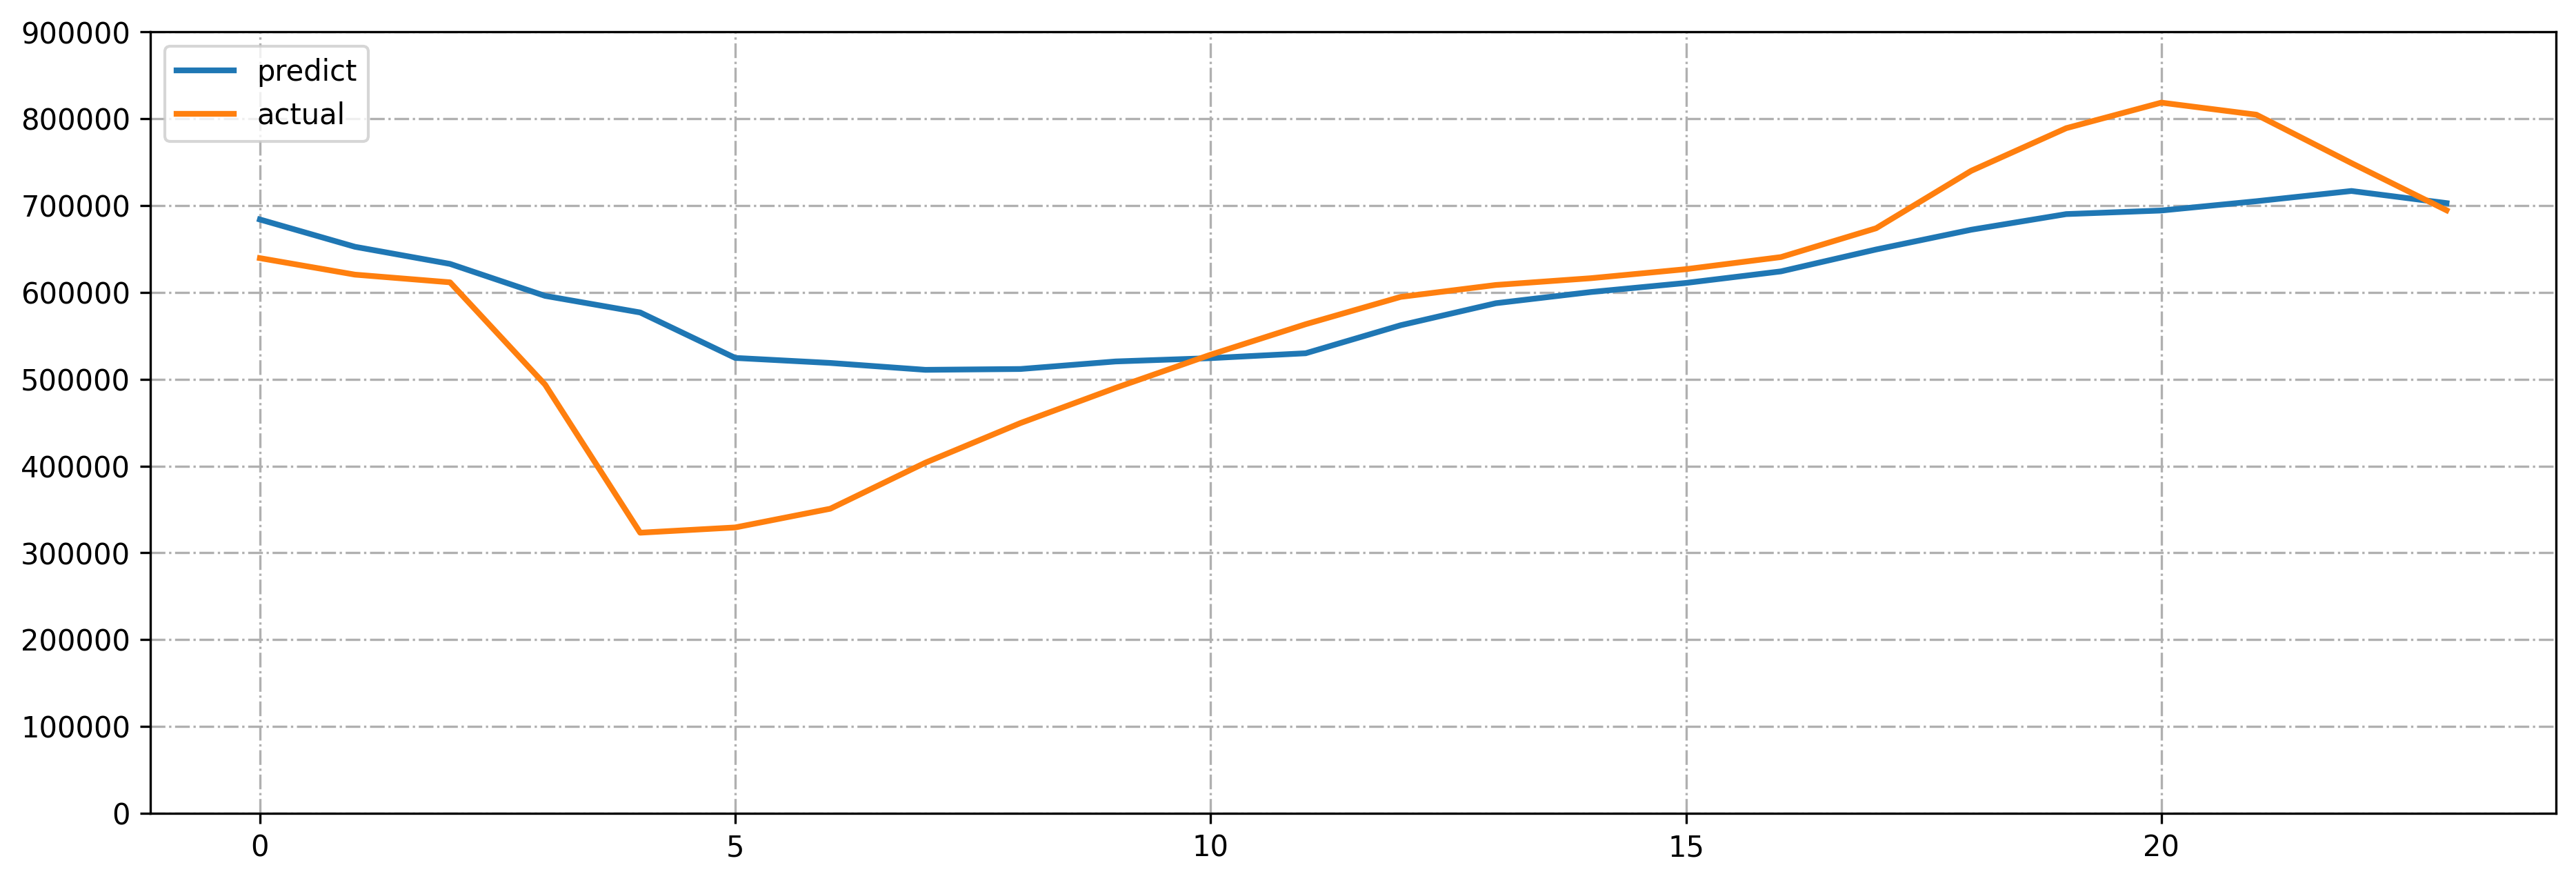

In [14]:
predict = validation
actual = actual
x = [x for x in range(24)]
fig, ax = plt.subplots(figsize=(15,5),dpi = 300)
ax.plot(x, predict, linewidth=2.0,label = "predict")
ax.plot(x, actual, linewidth=2.0,label = "actual")
ax.legend(loc=2);
# ax.set_title(bf_name)
plt.ylim((0, 900000))
plt.grid(linestyle='-.')
plt.show()

In [15]:
#ACC
error = 0
summery = 0
for i in range(24):
    error += abs(predict[i] - actual[i])
    summery += actual[i]
acc = 1 - error/summery
acc

0.8861790722717982